### Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model. We will then handle imbalance in data using various techniques and improve f1-score

In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('data/customer_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### CustomerID is not required, so dropping it

In [19]:
df.drop('customerID', axis='columns', inplace=True)

In [20]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

###  TotalCharges should be float but it is an object. Let's check what's going on with  this column

In [22]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

let's convert this string to number

In [23]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

### some string is empty, so converting to number is error

In [24]:
pd.to_numeric(df.TotalCharges, errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [25]:
df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [26]:
df.shape

(7043, 20)

In [27]:
df.iloc[488].TotalCharges

' '

In [28]:
df[df.TotalCharges!=' '].shape


(7032, 20)

### Remove all rows with TotalCharge having empty string

In [29]:
df1 = df[df.TotalCharges !=' ']
df1.shape

(7032, 20)

In [30]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [31]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

c:\python_env\datascience\deep learning with python tensorflow\venv_deeplearning\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [32]:
df1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [33]:
df1[df1.Churn=='No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


## Data Visualization

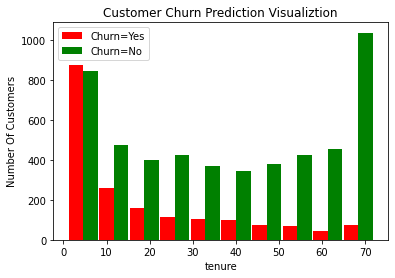

In [34]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

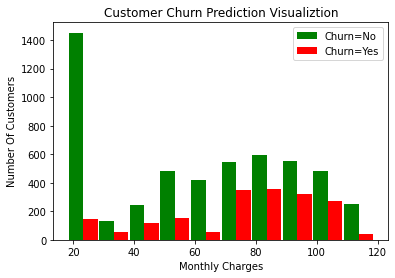

In [35]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges      
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges 

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")


plt.hist([mc_churn_no, mc_churn_yes], rwidth=0.95, color=['green','red'],label=['Churn=No','Churn=Yes'])
plt.legend()

In [36]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

**Many of the columns are yes, no etc. Let's print unique values in object columns to see data values**

In [37]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**

In [38]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

c:\python_env\datascience\deep learning with python tensorflow\venv_deeplearning\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [39]:
print_unique_col_values(df1)


gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Convert Yes and No to 1 or 0**

In [40]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

c:\python_env\datascience\deep learning with python tensorflow\venv_deeplearning\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [41]:
for col in df1:
    print(f'{col}: {df1[col].unique()}') 

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [42]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

In [43]:
df1.gender.unique()

array([1, 0], dtype=int64)

**One hot encoding for categorical columns**

In [44]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [45]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
392,1,1,0,0,2,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3770,1,0,1,0,57,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
5881,1,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
1347,0,0,0,0,19,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4559,0,0,0,0,6,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0


In [46]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

In [47]:
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [48]:
cols_to_scale = ['TotalCharges', 'MonthlyCharges', 'tenure']

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [50]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

## Train Test Split

In [51]:
X = df2.drop('Churn', axis='columns')
y = df2['Churn']

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=5)

In [53]:
X_train.shape

(5625, 26)

In [54]:
X_test.shape

(1407, 26)

In [55]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0
101,1,0,1,1,0.000000,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2621,0,0,1,0,0.985915,1,0,0,1,1,...,1,0,0,0,0,1,0,1,0,0
392,1,1,0,0,0.014085,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1327,0,0,1,0,0.816901,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
3607,1,0,0,0,0.169014,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2773,0,0,1,0,0.323944,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1936,1,0,1,0,0.704225,1,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
5387,0,0,0,0,0.042254,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4331,0,0,0,0,0.985915,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [56]:
len(X_train.columns)

26

## Build a ANN Model using tensorflow and keras

In [58]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report

In [60]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(26, input_dim=26, activation='relu'),
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

In [61]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
176/176 [==============================] - 1s 1ms/step - loss: 0.5120 - accuracy: 0.7468
Epoch 2/100
176/176 [==============================] - 0s 977us/step - loss: 0.4287 - accuracy: 0.7980
Epoch 3/100
176/176 [==============================] - 0s 880us/step - loss: 0.4199 - accuracy: 0.8002
Epoch 4/100
176/176 [==============================] - 0s 829us/step - loss: 0.4157 - accuracy: 0.8044
Epoch 5/100
176/176 [==============================] - 0s 897us/step - loss: 0.4118 - accuracy: 0.8062
Epoch 6/100
176/176 [==============================] - 0s 869us/step - loss: 0.4100 - accuracy: 0.8073
Epoch 7/100
176/176 [==============================] - 0s 903us/step - loss: 0.4079 - accuracy: 0.8092
Epoch 8/100
176/176 [==============================] - 0s 989us/step - loss: 0.4064 - accuracy: 0.8112
Epoch 9/100
176/176 [==============================] - 0s 829us/step - loss: 0.4049 - accuracy: 0.8108
Epoch 10/100
176/176 [==============================] - 0s 823us/step - los

## Mitigating Skewdness of data

Method 1 - UnderSampling

In [63]:
df2[df2['Churn'] == 0].shape, df2[df2['Churn'] == 1].shape

((5163, 27), (1869, 27))

In [64]:
# Class count
count_class_0, count_class_1 = df1.Churn.value_counts()

# Divide by class
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]


# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
0    1869
1    1869
Name: Churn, dtype: int64


In [65]:
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [66]:
# Number of classes in training Data
y_train.value_counts()

0    1495
1    1495
Name: Churn, dtype: int64

In [67]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 0.6035 - accuracy: 0.7010
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 0.5073 - accuracy: 0.7545
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4879 - accuracy: 0.7722
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4815 - accuracy: 0.7709
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4770 - accuracy: 0.7696
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4729 - accuracy: 0.7722
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4700 - accuracy: 0.7769
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4685 - accuracy: 0.7783
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4653 - accuracy: 0.7833
Epoch 10/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4642 - accuracy: 0.7803
Epoch 11/

## Method 2- Oversampling

In [68]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
0    5163
1    5163
Name: Churn, dtype: int64


In [69]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [70]:
# Number of classes in training Data
y_train.value_counts()

1    4130
0    4130
Name: Churn, dtype: int64

In [71]:
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 1s 1ms/step - loss: 0.5423 - accuracy: 0.7299
Epoch 2/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.7676
Epoch 3/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4756 - accuracy: 0.7759
Epoch 4/100
259/259 [==============================] - 0s 938us/step - loss: 0.4713 - accuracy: 0.7751
Epoch 5/100
259/259 [==============================] - 0s 798us/step - loss: 0.4676 - accuracy: 0.7800
Epoch 6/100
259/259 [==============================] - 0s 834us/step - loss: 0.4647 - accuracy: 0.7801
Epoch 7/100
259/259 [==============================] - 0s 849us/step - loss: 0.4608 - accuracy: 0.7815
Epoch 8/100
259/259 [==============================] - 0s 868us/step - loss: 0.4582 - accuracy: 0.7840
Epoch 9/100
259/259 [==============================] - 0s 870us/step - loss: 0.4551 - accuracy: 0.7829
Epoch 10/100
259/259 [==============================] - 0s 880us/step - loss: 0

## Method 3: SMOTE

### To install imbalanced-learn library use **pip install imbalanced-learn** command

In [73]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [75]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X,y)

y_sm.value_counts()

0    5163
1    5163
Name: Churn, dtype: int64

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [77]:
# Number of classes in training Data
y_train.value_counts()

1    4130
0    4130
Name: Churn, dtype: int64

In [78]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)


Epoch 1/100
259/259 [==============================] - 1s 1ms/step - loss: 0.5581 - accuracy: 0.7207
Epoch 2/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4737 - accuracy: 0.7740
Epoch 3/100
259/259 [==============================] - 0s 857us/step - loss: 0.4643 - accuracy: 0.7752
Epoch 4/100
259/259 [==============================] - 0s 888us/step - loss: 0.4589 - accuracy: 0.7821
Epoch 5/100
259/259 [==============================] - 0s 876us/step - loss: 0.4538 - accuracy: 0.7851
Epoch 6/100
259/259 [==============================] - 0s 938us/step - loss: 0.4493 - accuracy: 0.7880
Epoch 7/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4449 - accuracy: 0.7926
Epoch 8/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4413 - accuracy: 0.7898
Epoch 9/100
259/259 [==============================] - 0s 899us/step - loss: 0.4370 - accuracy: 0.7972
Epoch 10/100
259/259 [==============================] - 0s 740us/step - loss: 0.4

### Method4: Use of Ensemble with undersampling

In [79]:
df2.Churn.value_counts()


0    5163
1    1869
Name: Churn, dtype: int64

In [80]:
# Regain Original features and labels
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [82]:
y_train.value_counts()


0    4130
1    1495
Name: Churn, dtype: int64

model1 --> class1(1495) + class0(0, 1495)

model2 --> class1(1495) + class0(1496, 2990)

model3 --> class1(1495) + class0(2990, 4130)

In [84]:
df3 = X_train.copy()
df3['Churn'] = y_train

In [85]:
df3.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
684,1,0,0,0,0.000000,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2446,1,0,0,0,0.239437,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
1680,0,0,1,1,0.774648,1,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2220,0,0,1,0,1.000000,1,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0
2842,1,0,0,0,0.042254,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0


In [86]:
df3_class0 = df3[df3.Churn==0]
df3_class1 = df3[df3.Churn==1]

In [87]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train 

In [88]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 0, 1495)

y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 0s 1ms/step - loss: 0.6262 - accuracy: 0.6619
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 0.5195 - accuracy: 0.7552
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4964 - accuracy: 0.7699
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4887 - accuracy: 0.7719
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4852 - accuracy: 0.7726
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4821 - accuracy: 0.7749
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4785 - accuracy: 0.7732
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4763 - accuracy: 0.7749
Epoch 9/100
94/94 [==============================] - 0s 882us/step - loss: 0.4728 - accuracy: 0.7816
Epoch 10/100
94/94 [==============================] - 0s 925us/step - loss: 0.4745 - accuracy: 0.7726
Epoch

In [89]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 1495, 2990)

y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 1ms/step - loss: 0.6360 - accuracy: 0.6528
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 0.5157 - accuracy: 0.7569
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4980 - accuracy: 0.7565
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4880 - accuracy: 0.7662
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 0.4834 - accuracy: 0.7669
Epoch 6/100
94/94 [==============================] - 0s 989us/step - loss: 0.4785 - accuracy: 0.7682
Epoch 7/100
94/94 [==============================] - 0s 892us/step - loss: 0.4769 - accuracy: 0.7722
Epoch 8/100
94/94 [==============================] - 0s 860us/step - loss: 0.4737 - accuracy: 0.7696
Epoch 9/100
94/94 [==============================] - 0s 908us/step - loss: 0.4720 - accuracy: 0.7722
Epoch 10/100
94/94 [==============================] - 0s 892us/step - loss: 0.4709 - accuracy: 0.7746

In [90]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 2990, 4130)

y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
83/83 [==============================] - 1s 1ms/step - loss: 0.6162 - accuracy: 0.6994
Epoch 2/100
83/83 [==============================] - 0s 1ms/step - loss: 0.5138 - accuracy: 0.7609
Epoch 3/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4914 - accuracy: 0.7617
Epoch 4/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.7674
Epoch 5/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4791 - accuracy: 0.7723
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.4749 - accuracy: 0.7765
Epoch 7/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4706 - accuracy: 0.7769
Epoch 8/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4670 - accuracy: 0.7769
Epoch 9/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4655 - accuracy: 0.7829
Epoch 10/100
83/83 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.7837
Epoch 11/

In [91]:
len(y_pred1)

1407

In [92]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [93]:
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.90      0.70      0.78      1033
           1       0.48      0.78      0.59       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.78      0.72      0.73      1407

